In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

#!pip install tensorflow==2.11.0

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv1D,Dense, GlobalAveragePooling1D, Embedding, MultiHeadAttention
from tensorflow.keras.layers import MaxPool1D, Dropout, LayerNormalization, MaxPooling1D, Input
from tensorflow.keras.models import Sequential, Model

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#weight_address = '/content/drive/MyDrive/Virus-DNA-classification-BERT-main/old_code/data10/data5/'
#results_address = '/content/drive/MyDrive/Virus-DNA-classification-BERT-main/old_code/data10/data5/'
weight_address = '/content/drive/MyDrive/old_code/data10/data5/'
results_address = '/content/drive/MyDrive/old_code/data10/data5/'
drive_path = '/content/drive/MyDrive/old_code/data10/data5/'
NUM_CLASSES = 5

### The networks

#### Transformer

In [5]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.embed_dim = embed_dim
        self.token_emb = Embedding(input_dim= vocab_size, output_dim= embed_dim)
        self.maxlen = maxlen

    def get_angles(self, pos, i, embd_dim):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(embd_dim))
        return pos * angle_rates

    def positional_encoding(self, max_pos_enc, embd_dim):
        angle_rads = self.get_angles(np.arange(max_pos_enc)[:, np.newaxis],
                                np.arange(embd_dim)[np.newaxis, :],
                                embd_dim)

        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, x):
        positions = self.positional_encoding(max_pos_enc= self.maxlen, embd_dim= self.embed_dim)
        x = self.token_emb(x)
        return x + positions

In [6]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads= num_heads, key_dim= embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

### Transformer and CNN

In [7]:
@tf.autograph.experimental.do_not_convert # added to silence a warning related to TF
def create_model_cnn_transformer(maxlen = 29901, vocab_size = 10028,
                                embed_dim = 50, num_heads = 2,
                                ff_dim = 16, dout = 0.1,
                                filters = 64, kernel_size = 3,
                                pool_window = 2, extra_dense_nodes = 20, pool = 'maxpool',
                                summary = True):
    '''
    embed_dim - Embedding size for each token
    num_heads - Number of attention heads
    ff_dim - Hidden layer size in feed forward network inside transformer
    pool - can be "maxpool" for local maxpooling or "globalAvg" for global average pooling
    '''
    # input
    inputs = Input(shape=(maxlen,))
    # embeddding
    embedding_layer = TokenAndPositionEmbedding(inputs.shape[1], vocab_size, embed_dim)
    x = embedding_layer(inputs)
    # convolution
    x = Conv1D(filters= filters, kernel_size= kernel_size)(x)
    if pool == 'maxpool':
        x = MaxPooling1D(pool_size= pool_window)(x)
    else:
        print('the feature not working yet')

    print(x.shape)
    # transformer
    transformer_block = TransformerBlock(filters, num_heads, ff_dim)
    # print('transformer_block input shape:', x.shape)
    x = transformer_block(x)
    # extra dense layers
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dout)(x)
    if extra_dense_nodes!= 0:
        x = Dense(extra_dense_nodes, activation= "relu")(x)
        x = Dropout(dout)(x)
    # output
    outputs = Dense(NUM_CLASSES, activation= "softmax")(x)

    model= Model(inputs=inputs, outputs= outputs)
    if summary:
        model.summary()

    return model

### CNN

In [8]:
def create_CNN_model(layers = 2, filters = [32, 64, 128], kernel_size= 3,
                      embed_dim = 50, vocab_size = 10027, summary= False):

    model = Sequential()
    model.add(Embedding(vocab_size+1, embed_dim))#, input_length = X_train_padded.shape[1]))

    for i in range(layers):
        model.add(Conv1D(filters = filters[i], kernel_size = kernel_size, activation='relu'))
        model.add(MaxPool1D(pool_size = 2, strides=2))

    model.add(GlobalAveragePooling1D())
    model.add(Dense(NUM_CLASSES, activation= 'softmax'))
    if summary:
        model.summary()
    return model

### Kmer method

#### Loading the saved data

In [9]:
with open(drive_path + 'X_train_k6.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open(drive_path + 'Y_train_k6.pkl', 'rb') as f:
    Y_train = pickle.load(f)

X_train.shape, Y_train

((2000, 29901),
 2055    4
 1961    3
 1864    3
 2326    4
 461     0
        ..
 1638    3
 1095    2
 1130    2
 1294    2
 860     1
 Name: label, Length: 2000, dtype: int64)

In [10]:
with open(drive_path + 'X_test_list_k6.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open(drive_path + 'Y_test_list_k6.pkl', 'rb') as f:
    Y_test = pickle.load(f)

X_test.shape, Y_test

((500, 29901),
 array([2, 2, 2, 4, 3, 1, 3, 4, 0, 4, 0, 0, 1, 2, 1, 1, 2, 3, 0, 2, 4, 1,
        4, 4, 0, 1, 2, 2, 2, 1, 2, 0, 2, 4, 1, 2, 3, 2, 3, 2, 4, 2, 3, 2,
        1, 3, 2, 0, 3, 4, 0, 3, 1, 0, 0, 0, 2, 2, 3, 2, 4, 2, 0, 4, 0, 2,
        2, 0, 1, 0, 1, 4, 4, 2, 2, 2, 2, 4, 2, 0, 3, 0, 4, 0, 2, 3, 4, 0,
        3, 3, 3, 1, 0, 1, 1, 2, 2, 3, 2, 0, 4, 4, 4, 3, 1, 2, 0, 1, 2, 1,
        2, 4, 2, 4, 1, 1, 3, 3, 3, 3, 0, 0, 0, 3, 4, 0, 1, 4, 3, 0, 0, 3,
        4, 3, 2, 0, 2, 1, 0, 0, 3, 2, 2, 2, 2, 2, 2, 0, 1, 4, 0, 2, 1, 1,
        1, 3, 3, 3, 0, 3, 2, 3, 1, 0, 0, 4, 1, 4, 4, 3, 4, 1, 1, 2, 1, 1,
        1, 0, 3, 1, 3, 0, 0, 2, 1, 2, 4, 1, 0, 2, 4, 2, 1, 2, 2, 2, 1, 1,
        1, 2, 2, 0, 4, 2, 1, 3, 0, 2, 2, 0, 4, 0, 4, 3, 3, 2, 3, 3, 4, 1,
        3, 4, 3, 4, 4, 3, 3, 2, 3, 3, 4, 3, 3, 1, 1, 1, 0, 2, 4, 4, 1, 3,
        2, 3, 1, 1, 0, 3, 1, 1, 2, 2, 3, 2, 0, 3, 3, 2, 0, 4, 2, 0, 3, 0,
        3, 3, 2, 1, 2, 4, 0, 0, 4, 2, 0, 3, 2, 0, 3, 0, 0, 3, 3, 1, 1, 3,
        0, 2, 3, 3, 1, 

#### Training helpers

In [11]:
model_names = ['transformer_cnn_k3_32f_4pool',
            'transformer_cnn_k3_64f_4pool',
            'transformer_cnn_k3_128f_4pool',
            'cnn_k3_2layers']

In [12]:
lr_decay = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    verbose= 1
    )

es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    verbose=1,
    patience=5,
    mode="auto",
    restore_best_weights=True,
)

adam_opt = tf.keras.optimizers.Adam(learning_rate=0.001)

In [13]:
def evaluate_model(model, model_name):
    model.load_weights(weight_address+model_name) # loads the best weight before evaluating
    print('Test F1 score:')
    preds = np.argmax(model.predict(X_test, batch_size=8), axis = 1)
    score = f1_score(Y_test, preds, average = 'weighted')
    print(score)

In [14]:
def plot_history(history, model_name):
    print('Highest train acc: {:.3f} epoch: {}\nHighest val acc: {:.3f} epoch: {}'\
        .format(max(history.history['accuracy']), 1+np.argmax(np.array(history.history['accuracy'])),
                max(history.history['val_accuracy']), 1+np.argmax(np.array(history.history['val_accuracy']))))

    plt.title('Training history of '+ model_name)
    plt.plot(history.history['accuracy'],'ro-')
    plt.plot(history.history['val_accuracy'],'bx-')
    plt.legend(['accuracy','val_accuracy'])
    plt.savefig(results_address+model_name+'.png')
    plt.show()

In [15]:
def make_checkpointer(model_name):
    return tf.keras.callbacks.ModelCheckpoint(
    weight_address+model_name, monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True)

In [16]:
metrics = ['accuracy']

#### Training

data with pool size smaller than 4 does not fit in my GPU

In [ ]:
eps = 15

transformer_cnn_k3_32f_4pool
(None, 7474, 32)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29901)]           0         
                                                                 
 token_and_position_embeddin  (None, 29901, 50)        501400    
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 conv1d (Conv1D)             (None, 29899, 32)         4832      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7474, 32)         0         
 )                                                               
                                                                 
 transformer_block (Transfor  (None, 7474, 32)         9616      
 merBlock)     

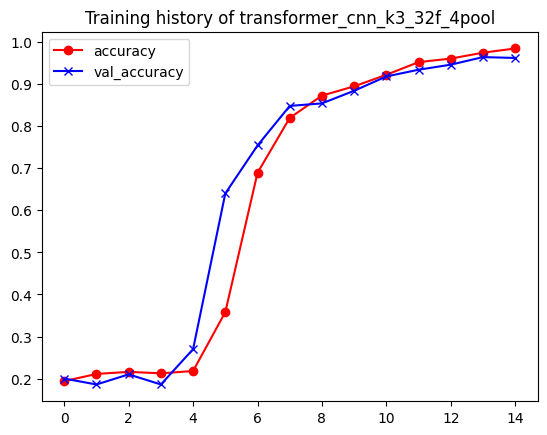

Test F1 score:
63/63 [==============================] - 13s 201ms/step
0.9638517867636078


In [ ]:
model_name = model_names[0]
print(model_name)

check_point = make_checkpointer(model_name)
model = create_model_cnn_transformer(filters=32, pool_window=4)

model.compile(optimizer=adam_opt, loss= "sparse_categorical_crossentropy", metrics= metrics)

history = model.fit(X_train, Y_train,
                    batch_size=8, epochs=eps,
                    validation_data=(X_test, Y_test),
                    callbacks = [check_point, lr_decay])

plot_history(history, model_name)
evaluate_model(model, model_name)


63/63 [==============================] - 13s 202ms/step


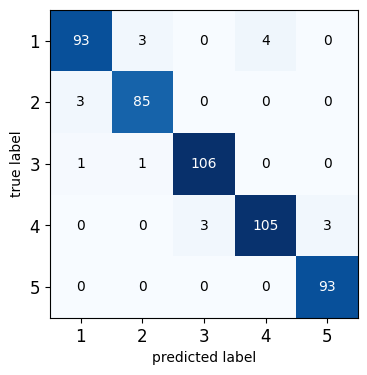

In [ ]:
predictions = model.predict(X_test, batch_size = 8)
predictions = np.argmax(predictions, axis = -1)
labels = Y_test

cm  = confusion_matrix(labels, predictions)
plot_confusion_matrix(cm,figsize=(4,4), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(NUM_CLASSES), [i+1 for i in range(NUM_CLASSES)], fontsize=12)
plt.yticks(range(NUM_CLASSES), [i+1 for i in range(NUM_CLASSES)], fontsize=12)
plt.show()

In [17]:
eps = 15

transformer_cnn_k3_64f_4pool
(None, 7474, 64)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29901)]           0         
                                                                 
 token_and_position_embeddin  (None, 29901, 50)        501400    
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 conv1d (Conv1D)             (None, 29899, 64)         9664      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7474, 64)         0         
 )                                                               
                                                                 
 transformer_block (Transfor  (None, 7474, 64)         35600     
 merBlock)     

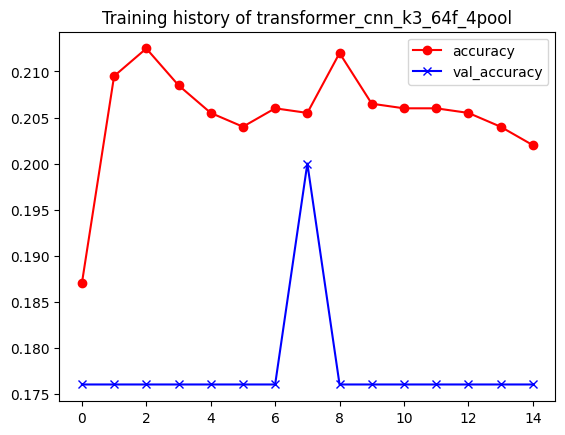

Test F1 score:
63/63 [==============================] - 33s 515ms/step
0.05268027210884354


In [18]:
model_name = model_names[1]
print(model_name)
check_point = make_checkpointer(model_name)

model = create_model_cnn_transformer(filters=64, pool_window=4)

model.compile(optimizer= adam_opt, loss= "sparse_categorical_crossentropy", metrics=metrics)

history = model.fit(X_train, Y_train,
                    batch_size=8, epochs=eps,
                    validation_data=(X_test, Y_test),
                    callbacks = [check_point, lr_decay])

plot_history(history, model_name)
evaluate_model(model, model_name)

63/63 [==============================] - 30s 477ms/step


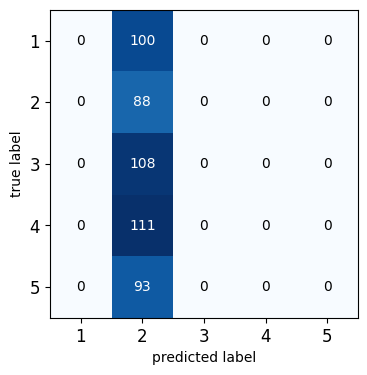

In [19]:
predictions = model.predict(X_test, batch_size = 8)
predictions = np.argmax(predictions, axis = -1)
labels = Y_test

cm  = confusion_matrix(labels, predictions)
plot_confusion_matrix(cm,figsize=(4,4), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(NUM_CLASSES), [i+1 for i in range(NUM_CLASSES)], fontsize=12)
plt.yticks(range(NUM_CLASSES), [i+1 for i in range(NUM_CLASSES)], fontsize=12)
plt.show()

In [17]:
eps = 15

cnn_k3_2layers
Epoch 1/15
250/250 [==============================] - 87s 335ms/step - loss: 1.6092 - accuracy: 0.2160 - val_loss: 1.6036 - val_accuracy: 0.1860 - lr: 0.0010
Epoch 2/15
250/250 [==============================] - 54s 214ms/step - loss: 1.5853 - accuracy: 0.2525 - val_loss: 1.5637 - val_accuracy: 0.3280 - lr: 0.0010
Epoch 3/15
250/250 [==============================] - 35s 140ms/step - loss: 1.5126 - accuracy: 0.3680 - val_loss: 1.4509 - val_accuracy: 0.3420 - lr: 0.0010
Epoch 4/15
250/250 [==============================] - 29s 118ms/step - loss: 1.0735 - accuracy: 0.5760 - val_loss: 0.8190 - val_accuracy: 0.7220 - lr: 0.0010
Epoch 5/15
250/250 [==============================] - 29s 115ms/step - loss: 0.6170 - accuracy: 0.8075 - val_loss: 0.5128 - val_accuracy: 0.7380 - lr: 0.0010
Epoch 6/15
250/250 [==============================] - 16s 63ms/step - loss: 0.3075 - accuracy: 0.9665 - val_loss: 0.1861 - val_accuracy: 0.9980 - lr: 0.0010
Epoch 7/15
250/250 [==================

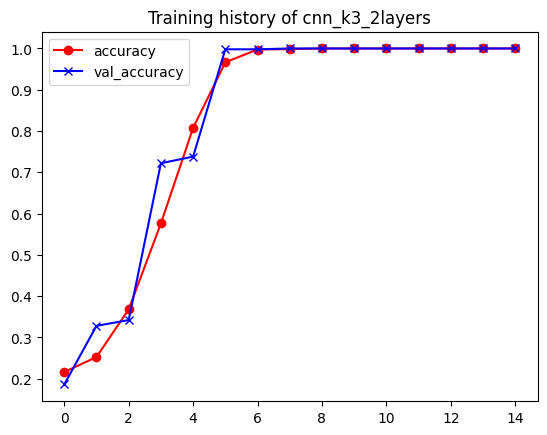

Test F1 score:
63/63 [==============================] - 1s 9ms/step
1.0


In [18]:
model_name = model_names[3]
print(model_name)

check_point = make_checkpointer(model_name)
model = create_CNN_model(layers=2, kernel_size=3)

model.compile(optimizer= adam_opt, loss= "sparse_categorical_crossentropy", metrics= metrics)

history = model.fit(X_train, Y_train,
                    batch_size=8, epochs=eps,
                    validation_data=(X_test, Y_test),
                    callbacks = [check_point, lr_decay])

plot_history(history, model_name)
evaluate_model(model, model_name)

63/63 [==============================] - 2s 37ms/step


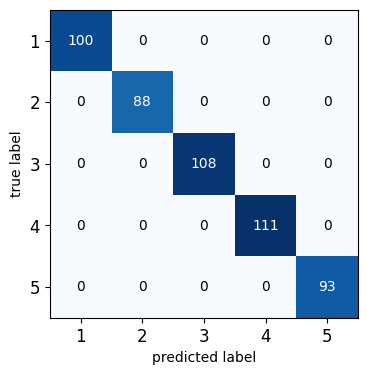

In [19]:
predictions = model.predict(X_test, batch_size = 8)
predictions = np.argmax(predictions, axis = -1)
labels = Y_test

cm  = confusion_matrix(labels, predictions)
plot_confusion_matrix(cm,figsize=(4,4), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(NUM_CLASSES), [i+1 for i in range(NUM_CLASSES)], fontsize=12)
plt.yticks(range(NUM_CLASSES), [i+1 for i in range(NUM_CLASSES)], fontsize=12)
plt.show()